# Analysis of Tom20 Mitos data taken 4/09/21 on 2 color STED

## Previously done steps:
1. Use Weka segmentation to segment mitochondria from the rest of the cell (using defaults)
2. Masked out the non-mitos to zero values
3. Use Thunderstorm to localize and fit the Tom20 clusters and exported the csv file with the fit data (using defaults)
3. Looked at the FFT along the mitos to see if any particular frequencies pop up-no obvious signal (done with data on old 2 color STED)

## To do now:
* Mitos analysis steps:
    * Size of Tom20 clusters-start with a basic method, later I can try their method if my results don’t make sense
        * Find the average size of the Tom20 clusters in each image (and std) using Thunderstorm csv output
        * Plot the 5 images under the same conditions in a boxcar plot-how is heterogeneity?
        * Plot the different conditions and controls in a boxcar plot, adding together all the images into one dataset
        * maybe do some hypothesis testing of any differences found?
    * Density of Tom20 clusters in mitochondria-their method seems complex, I’m not sure if it’s strictly necessary, so start with a basic method and see if it gets me any useful results
        * calculate total area of mitochondria in an image using the mitos masks
        * calculate the number of spots in the image using Thunderstorm output
        * divide spot number by area for each image
        * compare the results for images under same conditions-find average and std for each condition
        * Hypothesis testing?
    * Normalized variance of fluorescence signal
        * From Mitos paper: “the local variance in the fluorescence intensity of raw STED images was calculated before image segmentation. To this end, the variance was determined in round ROIs with a diameter of seven pixels (∼140 nm). The resulting variance values were assigned to the central pixel of the analyzed ROI. To evaluate the results of the analysis independently from the absolute brightness of the struc- tures, the individual variance values were normalized to the squared average fluorescence intensity of the respective ROI. The variance calculation was repeated using each pixel successively as an ROI center, leading to an image in which each pixel represents the local variance. Finally, the mitochondria-containing fraction of the image was selected by image segmentation using masks as described above. Then, the median of the variance within the mitochondria was determined.”
        * Calculate the fluorescence variance in a round ROI of size ~140 nm for every pixel in the image (except edges of course)
        * Normalize individual variance values for each pixel to the squared average fluorescence intensity of the ROI
        * Then use the mitos mask to segment the image to keep only the pixels in the inside of the mitos
        * Calculate median of the normalized fluorescence values of the pixels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math as m
import os

## Import the data
#### Put the folder names where the data for each sample live

one folder named YYMMDD contains all the folders with the different analysis steps
For same sample data taken on different days, move
* "...STED Data/YYMMDD/Type/YYYY-MM-DD Pierce S "
* then one of the following:
* Decon 3D = deconvolved stack
* Decon = deconvolved middle images
* Stable = stabilized STED images, not deconvolved yet
* Masks = masks output in different folders for different classifiers
* Mitos = Decon STED image multiplied by the Masks-diff folders for diff classifiers
* Conf = Confocal images
* TStorm = Thunderstorm output files, in different folders for different classifiers, may also add folders for different TStorm methods/settings

- List different classifiers as folders in Masks, Mitos
- TStorm will have classifiers listed as folder, plus possibly different settings for TStorm?


In [2]:
C1_folder = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/230802/Control/2023-08-02 Pierce S "
Glu1_folder = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/230825/Glutamate/2023-08-25 Pierce S "
FAP1_folder = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/230908/FAP_3hours/2023-09-08 Pierce S "

In [3]:
C2_folder = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/231019/Control2/2023-10-19 Pierce S "
C2_folder2 = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/231117/Control2/2023-11-17 Pierce S "
Glu2_folder = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/231117/Glu2/2023-11-17 Pierce S "
FAP2_folder = "/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/From Dropbox/STED/STED Data/231019/4AP2_3hours/2023-10-19 Pierce S "

### Here list the folders for the final set of data, may need to put more than one folder together for full set of images for each sample

In [4]:
#C_folders = [C1_folder,C2_folder, C2_folder2]
C_folders = [C1_folder,C2_folder] # Wait for Stable for C2_folder2
C_classifiers = ["IMG0021_Control_Classifier2","IMG0013 classifier"]
Glu_folders = [Glu1_folder] #Wait for Stable and decon3D images for analysis of Glu2
Glu_classifiers = ["Glutamate_Image14_Traindata_classifier_2"]
FAP_folders = [FAP1_folder, FAP2_folder] #
FAP_classifiers = ["IMG0041_4AP_classifier","IMG0012 4AP classifier"]

In [5]:
#For each classifier/TStorm settings combo, read in .csv file into a Pandas dataframe
#inpub classifier name
def process_folders(folder_paths, classifiers):
    #folder_paths = list of folders with data for this type of sample
    #classifier = name of classifier I want to analyze results from (ie name of folder where masks, mitos and Tstorm data are in
    #TStorm = CONSIDER ADDING FOR DIFFERENT TSTORM ANALYSIS EVETUALLY, BUT FOR NOW DON'T WORRY ABOUT IT
    masks_all = []
    TStormResults_all = []
    tiffs_stable_all = []

    for folder_path, classifier in zip(folder_paths, classifiers):
        #For each folder, read in stable STED data for calculating variance in fluorescence
        folder_path_stable = folder_path + "Stable"
        files_and_subfolders = os.listdir(folder_path_stable)
        files_stable = [file for file in files_and_subfolders if file.endswith("_stable.tif")]
        print("List of names of Stable STED raw image files:")
        print(files_stable)
        tiffs_stable = []
        for file in files_stable:
            tiffs_stable = tiffs_stable + [plt.imread(os.path.join(folder_path_stable, file))]
        tiffs_stable_all = tiffs_stable_all + [tiffs_stable]
 
        #Read in Masks file inside classifier folder
        folder_path_masks = folder_path + "Masks" +"/" + classifier
        files_and_subfolders = os.listdir(folder_path_masks)                     
        files_masks = [file for file in files_and_subfolders if file.endswith("_mask.tif")]
        masks = []
        for file in files_masks:
            masks = masks + [plt.imread(os.path.join(folder_path_masks, file))]

        masks_all = masks_all + [masks] #list of lists of tiff files
        
        #Read in TStorm data
        folder_path_TStorm = folder_path + "TStorm" +"/" + classifier
        files_and_subfolders = os.listdir(folder_path_TStorm)                     
        files_TStorm = [file for file in files_and_subfolders if file.endswith(".csv")]
        TStormResults = []
        for file in files_TStorm:
            TStormResults = TStormResults + [pd.read_csv(os.path.join(folder_path_TStorm, file))]
        TStormResults_all = TStormResults_all + [TStormResults]
    return tiffs_stable_all, masks_all, TStormResults_all




                                                         
            
            


In [6]:
C_stable_tiffs, C_masks, C_TStorm = process_folders(C_folders, C_classifiers)

List of names of Stable STED raw image files:
['IMG0012_Control_STED_stable.tif', 'IMG0016_Control_STED_stable.tif', 'IMG0009_Control_STED_stable.tif', 'IMG0015_Control_STED_stable.tif', 'IMG0011_Control_STED_stable.tif', 'IMG0020_Control_STED_stable.tif', 'IMG0017_Control_STED_stable.tif', 'IMG0018_Control_STED_stable.tif', 'IMG0013_Control_STED_stable.tif', 'IMG0021_Control_STED_stable.tif', 'IMG0014_Control_STED_stable.tif', 'IMG0007_Control_STED_stable.tif']
List of names of Stable STED raw image files:
['IMG0011_Control2_STED_stable.tif', 'IMG0018_Control2_STED_stable.tif', 'IMG0014_Control2_STED_stable.tif', 'IMG0016_Control2_STED_stable.tif', 'IMG0013_Control2_STED_stable.tif', 'IMG0009_Control2_STED_stable.tif']


In [7]:
Glu_stable_tiffs, Glu_masks, Glu_TStorm = process_folders(Glu_folders, Glu_classifiers)

List of names of Stable STED raw image files:
['IMG0023_Glutamate_Tom20_STED_stable.tif', 'IMG0031_Glutamate_Tom20_STED_stable.tif', 'IMG0018_Glutamate_Tom20_STED_stable.tif', 'IMG0025_Glutamate_Tom20_STED_stable.tif', 'IMG0016_Glutamate_Tom20_STED_stable.tif', 'IMG0029_Glutamate_Tom20_STED_stable.tif', 'IMG0033_Glutamate_Tom20_STED_stable.tif', 'IMG0021_Glutamate_Tom20_STED_stable.tif', 'IMG0035_Glutamate_Tom20_STED_stable.tif', 'IMG0014_Glutamate_Tom20_STED_stable.tif', 'IMG0027_Glutamate_Tom20_STED_stable.tif', 'IMG0019_Glutamate_Tom20_STED_stable.tif']


In [8]:
FAP_stable_tiffs, FAP_masks, FAP_TStorm = process_folders(FAP_folders, FAP_classifiers)

List of names of Stable STED raw image files:
['IMG0037_4AP_STED_stable.tif', 'IMG0038_4AP_STED_stable.tif', 'IMG0039_4AP_STED_stable.tif', 'IMG0044_4AP_STED_stable.tif', 'IMG0045_4AP_STED_stable.tif', 'IMG0041_4AP_STED_stable.tif', 'IMG0040_4AP_STED_stable.tif', 'IMG0043_4AP_STED_stable.tif', 'IMG0042_4AP_STED_stable.tif']
List of names of Stable STED raw image files:
['IMG0006_4AP_3_hours_STED_stable.tif', 'IMG0009_4AP_3_hours_STED_stable.tif', 'IMG0020_4AP_3_hours_STED_stable.tif', 'IMG0007_4AP_3_hours_STED_stable.tif', 'IMG0011_4AP_3_hours_STED_stable.tif', 'IMG0014_4AP_3_hours_STED_stable.tif', 'IMG0024_4AP_3_hours_STED_stable.tif', 'IMG0022_4AP_3_hours_STED_stable.tif', 'IMG0004_4AP_3_hours_STED_stable.tif', 'IMG0012_4AP_3_hours_STED_stable.tif', 'IMG0026_4AP_3_hours_STED_stable.tif', 'IMG0005_4AP_3_hours_STED_stable.tif']


## Now do Thunderstorm Fit FWHM analysis

### Analysis of TStorm Data from each sample, image

In [17]:
def analyze_TStorm(TStorm):
    FWHM_mean_all = []
    FWHM_std_all = []
    FWHM_all = []
    for sample in TStorm:
        num_images = len(sample)
        FWHM_mean = np.zeros(num_images)
        FWHM_std = np.zeros(num_images)
        FWHM = sample[0]['sigma [nm]']
        for i in range(num_images):
            FWHM_mean[i] = sample[i].mean()['sigma [nm]']
            FWHM_std[i] = sample[i].std()['sigma [nm]']
            if i!=0:
                FWHM = pd.concat([FWHM, sample[i]['sigma [nm]']],ignore_index = True)
        print("Mean FWHM:")
        print(FWHM_mean)
        print("STD:")
        print(FWHM_std)
        FWHM_mean_all = FWHM_mean_all + [FWHM_mean]
        FWHM_std_all = FWHM_std_all +[FWHM_std]
        FWHM_all =FWHM_all + [FWHM]
    return FWHM_mean_all, FWHM_std_all, FWHM_all

In [18]:
C_FWHM_mean, C_std, C_FWHM = analyze_TStorm(C_TStorm)

Mean FWHM:
[29.6088962  29.84470411 28.86046103 29.43326368 29.33634058 28.8077879
 30.42569861 28.48762212 29.16737932 30.61371547 29.43242222 30.4772407 ]
STD:
[7.47037332 7.25323417 6.9656431  7.28683059 7.30579559 6.48549633
 7.54031078 6.74639557 7.33929714 8.21380299 7.3343084  7.09453307]
Mean FWHM:
[27.78234662 27.39468659 29.0519103  26.4604254  28.7825595  29.05898741]
STD:
[7.37283854 6.37251385 7.79653669 5.92437278 7.51351533 7.66953177]


In [20]:
Glu_FWHM_mean, Glu_std, Glu_FWHM = analyze_TStorm(Glu_TStorm)

Mean FWHM:
[25.58797343 27.2884305  29.56245446 27.61950106 27.04553787 29.22417309
 27.6390289  29.69621722 27.62133406 29.46809351 27.5243253  27.28042156]
STD:
[6.543911   6.49021836 7.3693262  6.62820716 6.34099466 7.36279998
 7.37084974 7.27144442 6.1695569  7.56627246 6.44929252 5.90977589]


In [21]:
FAP_FWHM_mean, FAP_std, FAP_FWHM = analyze_TStorm(FAP_TStorm)

Mean FWHM:
[26.20008626 25.41047892 26.95448138 24.59985018 27.24327285 26.97654086
 28.96451699 26.34570038 26.43685529]
STD:
[6.0978802  6.88345303 6.65071396 6.07529222 6.83796042 6.17264482
 8.43142133 6.63499157 8.91401229]
Mean FWHM:
[26.89751858 30.04613756 30.22163395 28.35652427 27.16266225 28.3613444
 28.17066289 27.03969683 28.26424576 28.53312581 29.52440965 22.67045121]
STD:
[6.84107138 8.37778627 7.90202571 7.10574464 6.30406024 7.47849769
 8.02018241 6.84615935 7.22106576 7.22335023 7.66725807 9.14130691]


### Now Do some TStorm boxplots:

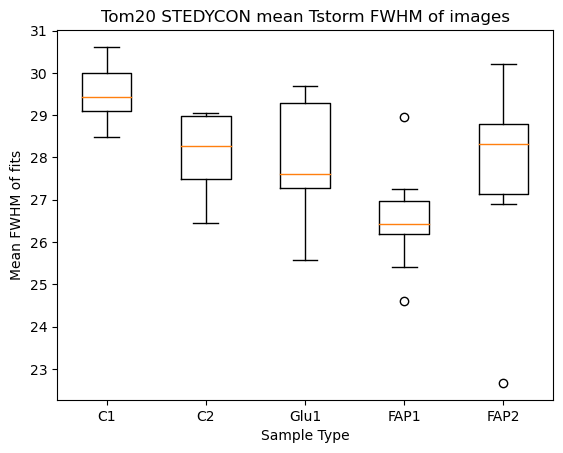

In [44]:
#data = [C_FWHM_mean[0], np.concatenate((C_FWHM_mean[1],C_FWHM_mean[2]), Glu_FWHM_mean[0], Glu_FWHM_mean[1], FAP_FWHM_mean[0]]
data = [C_FWHM_mean[0], C_FWHM_mean[1], Glu_FWHM_mean[0], FAP_FWHM_mean[0], FAP_FWHM_mean[1]]
fig1, ax1 = plt.subplots()
ax1.set_title('Tom20 STEDYCON mean Tstorm FWHM of images')
ax1.set_xlabel('Sample Type')
ax1.boxplot(data, labels=['C1','C2','Glu1','4AP1', '4AP2'])
ax1.set_ylabel('Mean FWHM of fits')
plt.show()

Something looks wrong!  The controls are very different in mean FWHM and the FAP's are also very different, and in the opposite direction.  Get the rest of my data before I worry about it, but I mean need to try using the same classifier again?

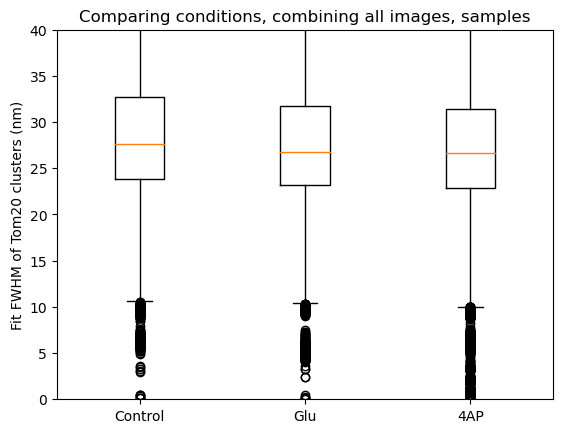

In [46]:
data = [np.concatenate((C_FWHM[0],C_FWHM[1])),Glu_FWHM[0],np.concatenate((FAP_FWHM[0], FAP_FWHM[1]))]
fig1, ax1 = plt.subplots()
ax1.set_title('Comparing conditions, combining all images, samples')
ax1.boxplot(data, labels=['Control','Glu','4AP'])
ax1.set_ylim([0,40])
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

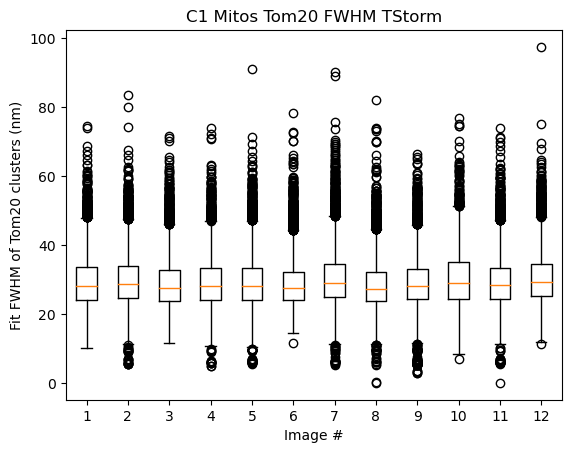

In [37]:
data1 = [result['sigma [nm]'] for result in C_TStorm[0]] 
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('C1 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data1)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

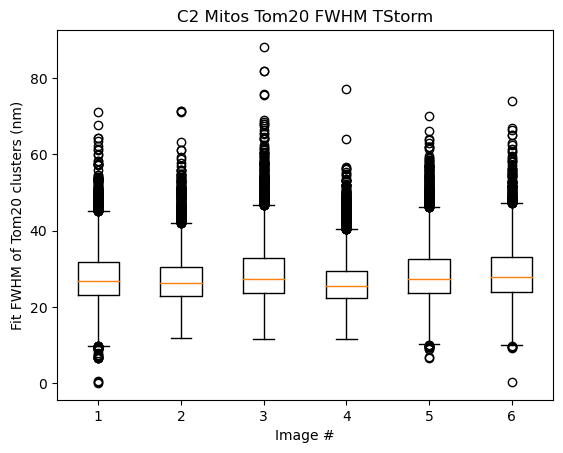

In [38]:
data2 = [result['sigma [nm]'] for result in C_TStorm[1]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('C2 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data2)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

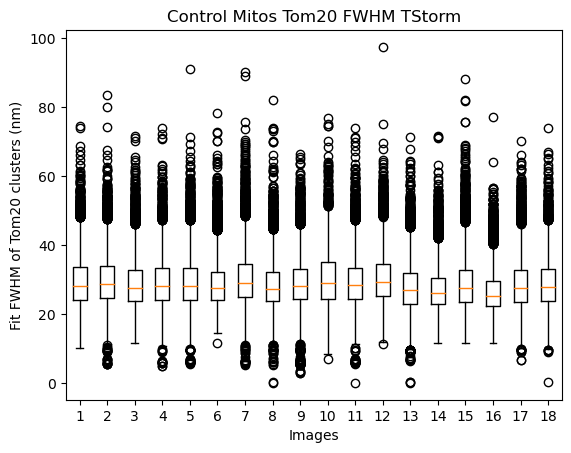

In [34]:
data = data1+data2
fig1, ax1 = plt.subplots()
ax1.set_title('Control Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Images')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

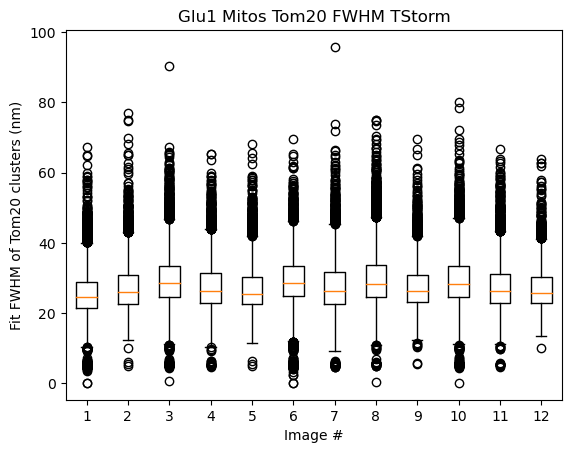

In [27]:
data = [result['sigma [nm]'] for result in Glu_TStorm[0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glu1 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

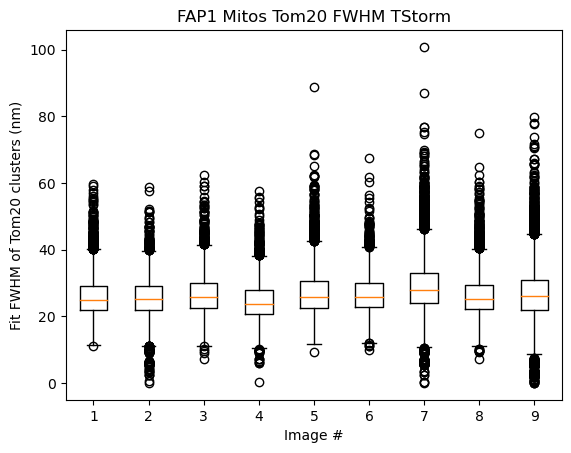

In [39]:
data1 = [result['sigma [nm]'] for result in FAP_TStorm[0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('FAP1 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data1)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

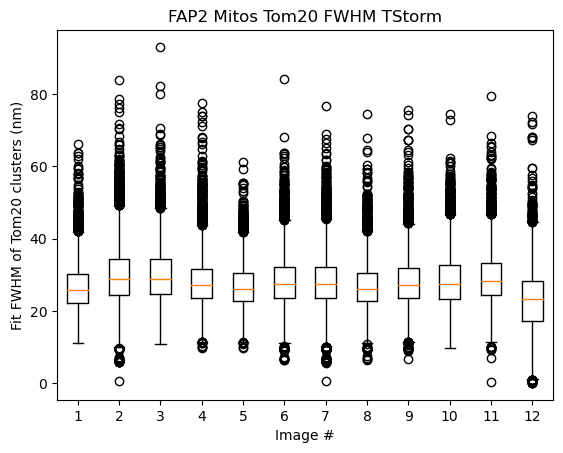

In [40]:
data2 = [result['sigma [nm]'] for result in FAP_TStorm[1]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('FAP2 Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data2)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

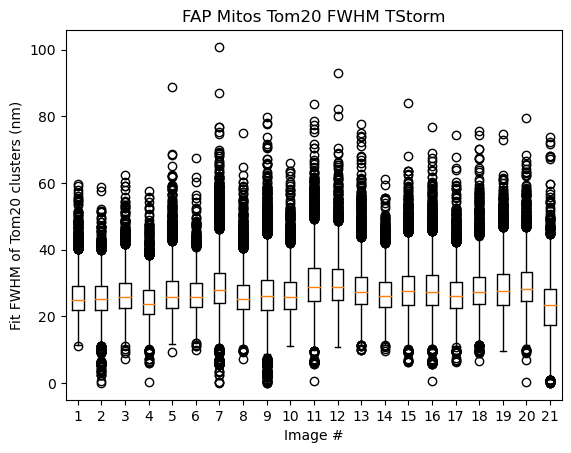

In [41]:
data=data1+data2
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('FAP Mitos Tom20 FWHM TStorm')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### List the mean and std of the different samples and combines mean/std

In [43]:
C1_mean = C_FWHM[0].mean()
C1_std = C_FWHM[0].std()
C2_mean = C_FWHM[1].mean()
C2_std = C_FWHM[1].std()
C_mean = pd.concat([C_FWHM[0], C_FWHM[1]],ignore_index = True).mean()
C_std = pd.concat([C_FWHM[0], C_FWHM[1]],ignore_index = True).std()

Glu1_mean = Glu_FWHM[0].mean()
Glu1_std = Glu_FWHM[0].std()

FAP1_mean = FAP_FWHM[0].mean()
FAP1_std = FAP_FWHM[0].std()
FAP2_mean = FAP_FWHM[1].mean()
FAP2_std = FAP_FWHM[1].std()
FAP_mean = pd.concat([FAP_FWHM[0], FAP_FWHM[1]],ignore_index = True).mean()
FAP_std = pd.concat([FAP_FWHM[0], FAP_FWHM[1]],ignore_index = True).std()

print('Control1 sigma mean +/- std')
print(f'{C1_mean:.2f}', ' +/- ', f'{C1_std:.2f}')
print('Control2 sigma mean +/- std')
print(f'{C2_mean:.2f}', ' +/- ', f'{C2_std:.2f}')
print('Control sigma mean +/- std')
print(f'{C_mean:.2f}', ' +/- ', f'{C_std:.2f}')
print('Glu1 sigma mean +/- std')
print(f'{Glu1_mean:.2f}', ' +/- ', f'{Glu1_std:.2f}')
print('FAP1 sigma mean +/- std')
print(f'{FAP1_mean:.2f}', ' +/- ', f'{FAP1_std:.2f}')
print('FAP2 sigma mean +/- std')
print(f'{FAP2_mean:.2f}', ' +/- ', f'{FAP2_std:.2f}')
print('FAP sigma mean +/- std')
print(f'{FAP_mean:.2f}', ' +/- ', f'{FAP_std:.2f}')

Control1 sigma mean +/- std
29.45  +/-  7.20
Control2 sigma mean +/- std
27.83  +/-  7.05
Control sigma mean +/- std
28.92  +/-  7.19
Glu1 sigma mean +/- std
28.06  +/-  6.99
FAP1 sigma mean +/- std
26.87  +/-  7.56
FAP2 sigma mean +/- std
28.09  +/-  7.75
FAP sigma mean +/- std
27.59  +/-  7.69


### Old method folder loading function

In [12]:
#OLD METHOD: For each classifier, list all the .csv files in the Tstorm folder
folder_paths = C_folders #list with all folders that have control data
file_type = '.csv'


C_subfolders = []
C_TStormResults_all = []

for folder_path in folder_paths:
    folder_path = folder_path+"TStorm"
    files_and_subfolders = os.listdir(folder_path)
    #subfolders should list the different classifiers and/or T
    subfolders = [file for file in files_and_subfolders if os.path.isdir(os.path.join(folder_path, file))]
    print(subfolders)
    C_subfolders = C_subfolders + [subfolders] #list of lists of subfolders for each Control data folder
    C_TStormResults = []
# Use a list comprehension to filter out files that do not match the file type
    for subfolder in subfolders:
        files = os.listdir(os.path.join(folder_path, subfolder))
        #print(files)
        match_files = [file for file in files if file.endswith(file_type)]
# Print the list of matching files
        #print(match_files)
        C_TStorm_Temp = []

        for file in match_files:
            temp = pd.read_csv(os.path.join(folder_path, subfolder, file))
            #print(temp.info())
            C_TStorm_Temp = C_TStorm_Temp + [temp] #list of databases for subfolder
        C_TStormResults = C_TStormResults +[C_TStorm_Temp]  #list of lists of pandas databases with TStorm results for each
    C_TStormResults_all = C_TStormResults_all + [C_TStormResults]

#print(C_TStormResults_all[0][0][5])


                                                         
            
            


## old method of loading data

In [331]:
df_4AP_4mM_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_1_deconv_10_TStorm1.csv')
df_4AP_4mM_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_2_deconv_10_TStorm1.csv')
df_4AP_4mM_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_3_deconv_10_TStorm1.csv')
df_4AP_4mM_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_4_deconv_10_TStorm1.csv')
df_4AP_4mM_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_4mM_5_deconv_10_TStorm1.csv')

In [332]:
df_4AP_control_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_1_deconv_10_TStorm1.csv')
df_4AP_control_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_2_deconv_10_TStorm1.csv')
df_4AP_control_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_3_deconv_10_TStorm1.csv')
df_4AP_control_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_4_deconv_10_TStorm1.csv')
df_4AP_control_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/4AP_control_5_deconv_10_TStorm1.csv')

In [333]:
df_glutamate_0p1uM_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_1_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_2_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_3_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_4_deconv_10_TStorm1.csv')
df_glutamate_0p1uM_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_0p1uM_5_deconv_10_TStorm1.csv')

In [334]:
df_glutamate_control_1 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_1_deconv_10_TStorm1.csv')
df_glutamate_control_2 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_2_deconv_10_TStorm1.csv')
df_glutamate_control_3 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_3_deconv_10_TStorm1.csv')
df_glutamate_control_4 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_4_deconv_10_TStorm1.csv')
df_glutamate_control_5 = pd.read_csv('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_TStorm1/glutamate_control_5_deconv_10_TStorm1.csv')

In [335]:
df_glutamate_control_1.head()

,id,frame,x [nm],y [nm],sigma [nm],intensity [photon],offset [photon],bkgstd [photon],uncertainty [nm]
0,1.0,1.0,90.969748,9059.325328,36.566546,401104.345544,6.101616e-06,4991.943561,4.205333
1,2.0,1.0,107.353146,11637.561925,29.065654,25986.592325,3.143694e-10,545.869455,4.487891
2,3.0,1.0,113.354460,12185.406431,33.343629,200835.290914,1.863189e-06,4065.500630,5.687433
3,4.0,1.0,184.990523,12964.563831,40.166659,76220.904552,1.144780e-07,835.383485,4.470502
4,5.0,1.0,145.138806,8927.422212,25.289741,108061.970620,4.699717e+03,1627.467235,2.435198


## Take mean of Thunderstorm Fit values for FWHM
For each type of sample, and for each imaging session, and for each analysis type, find the mean and std of the FWHM for each image

Start with keeping the images separate to see if they look very different, since lots of heterogeneity is seen in the different cells in the paper Ruth sent.  Probably need a lot more data to see this with statistical relevance if it's even an effect in our cells though.

###  Starting with Control:

In [70]:
C_FWHM_mean_all = []
C_FWHM_std_all = []
C_FWHM_all = []
for sample in C_TStormResults_all:
    num_images = len(sample[0])
    C_FWHM_mean = np.zeros(num_images)
    C_FWHM_std = np.zeros(num_images)
    C_FWHM_mean_temp = []
    C_FWHM_std_temp = []
    C_FWHM_temp = []
    for analysis in sample:
        C_FWHM = analysis[0]['sigma [nm]']
        for i in range(num_images):
            C_FWHM_mean[i] = analysis[i].mean()['sigma [nm]']
            C_FWHM_std[i] = analysis[i].std()['sigma [nm]']
            if i!=0:
                C_FWHM.append(analysis[i]['sigma [nm]'],ignore_index = True)
        C_FWHM_mean_temp = C_FWHM_mean_temp + [C_FWHM_mean]
        C_FWHM_std_temp = C_FWHM_std_temp = [C_FWHM_std]
        C_FWHM_temp = C_FWHM_temp +[C_FWHM]
    C_FWHM_mean_all = C_FWHM_mean_all + [C_FWHM_mean_temp]
    C_FWHM_std_all = C_FWHM_std_all +[C_FWHM_std_temp]
    C_FWHM_all = C_FWHM_all + [C_FWHM_temp]

print(C_FWHM_mean_all[0][0])
    

[29.6088962  29.84470411 28.86046103 29.43326368 29.33634058 28.8077879
 30.42569861 28.48762212 29.16737932 30.61371547 29.43242222 30.4772407 ]


### Glutamate

In [71]:
Glu_FWHM_mean_all = []
Glu_FWHM_std_all = []
Glu_FWHM_all = []
for sample in Glu_TStormResults_all:
    num_images = len(sample[0])
    Glu_FWHM_mean = np.zeros(num_images)
    Glu_FWHM_std = np.zeros(num_images)
    Glu_FWHM_mean_temp = []
    Glu_FWHM_std_temp = []
    Glu_FWHM_temp = []
    for analysis in sample:
        Glu_FWHM = analysis[0]['sigma [nm]']
        for i in range(num_images):
            Glu_FWHM_mean[i] = analysis[i].mean()['sigma [nm]']
            Glu_FWHM_std[i] = analysis[i].std()['sigma [nm]']
            if i != 0:
                Glu_FWHM.append(analysis[i]['sigma [nm]'],ignore_index = True)
        Glu_FWHM_mean_temp = Glu_FWHM_mean_temp + [Glu_FWHM_mean]
        Glu_FWHM_std_temp = Glu_FWHM_std_temp + [Glu_FWHM_std]
        Glu_FWHM_temp = Glu_FWHM_temp + [Glu_FWHM]
    Glu_FWHM_mean_all = Glu_FWHM_mean_all + [Glu_FWHM_mean_temp]
    Glu_FWHM_std_all = Glu_FWHM_std_all +[Glu_FWHM_std_temp]
    Glu_FWHM_all = Glu_FWHM_all +[Glu_FWHM_temp]

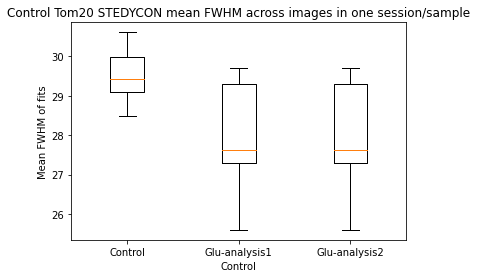

In [65]:
data = [C_FWHM_mean_all[0][0], Glu_FWHM_mean_all[0][0], Glu_FWHM_mean_all[0][1]]
fig1, ax1 = plt.subplots()
ax1.set_title('Control Tom20 STEDYCON mean FWHM across images in one session/sample')
ax1.set_xlabel('Control')
ax1.boxplot(data, labels=['Control','Glu-analysis1','Glu-analysis2'])
ax1.set_ylabel('Mean FWHM of fits')
plt.show()

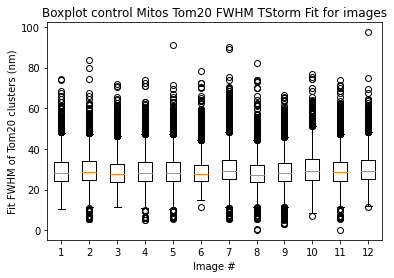

In [63]:
data = [result['sigma [nm]'] for result in C_TStormResults_all[0][0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot control Mitos Tom20 FWHM TStorm Fit for images')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

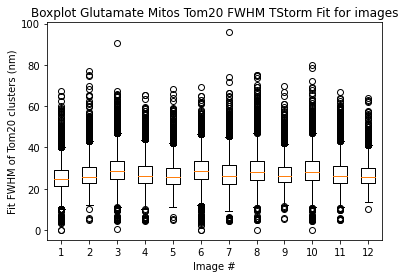

In [64]:
data = [result['sigma [nm]'] for result in Glu_TStormResults_all[0][0]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot Glutamate Mitos Tom20 FWHM TStorm Fit for images')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

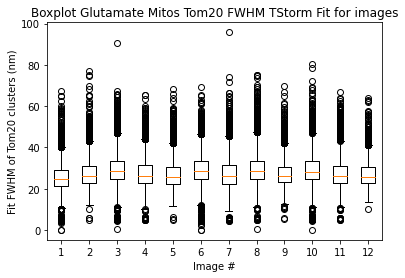

In [66]:
data = [result['sigma [nm]'] for result in Glu_TStormResults_all[0][1]]
#data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot Glutamate Mitos Tom20 FWHM TStorm Fit for images')
ax1.set_xlabel('Image #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### Now put all the results from each imaging session together and compare control to Glutamate and 4AP

In [80]:
C1_mean = C_FWHM_all[0][0].mean()
C1_std = C_FWHM_all[0][0].std()
Glu1_mean = Glu_FWHM_all[0][0].mean()
Glu1_std = Glu_FWHM_all[0][0].std()
Glu2_mean = Glu_FWHM_all[0][1].mean()
Glu2_std = Glu_FWHM_all[0][1].std()

print('Control sigma mean +/- std')
print(f'{C1_mean:.2f}', ' +/- ', f'{C1_std:.2f}')
print('Glutamate analysis 1 sigma mean +/- std')
print(f'{Glu1_mean:.2f}', ' +/- ', f'{Glu1_std:.2f}')
print('Glutamate analysis 2 sigma mean +/- std')
print(f'{Glu2_mean:.2f}', ' +/- ', f'{Glu2_std:.2f}')

Control sigma mean +/- std
29.61  +/-  7.47
Glutamate analysis 1 sigma mean +/- std
25.59  +/-  6.54
Glutamate analysis 2 sigma mean +/- std
25.59  +/-  6.55


Now do a boxplot for the data I currently have analyzed with Thunderstorm, comparing Mask types

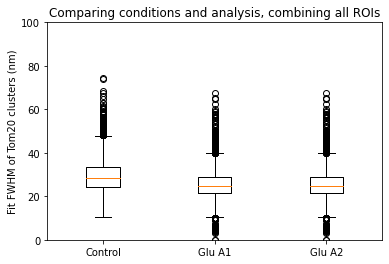

In [81]:
data = [C_FWHM_all[0][0], Glu_FWHM_all[0][0],Glu_FWHM_all[0][1]]
fig1, ax1 = plt.subplots()
ax1.set_title('Comparing conditions and analysis, combining all ROIs')
ax1.boxplot(data, labels=['Control','Glu A1','Glu A2'])
ax1.set_ylim([0,100])
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

## Old data leave here in case I need it for comparison

In [336]:
df_4AP_4mM_1_sigma_mean = df_4AP_4mM_1.mean()['sigma [nm]']
df_4AP_4mM_1_sigma_std = df_4AP_4mM_1.std()['sigma [nm]']
df_4AP_4mM_2_sigma_mean = df_4AP_4mM_2.mean()['sigma [nm]']
df_4AP_4mM_2_sigma_std = df_4AP_4mM_2.std()['sigma [nm]']
df_4AP_4mM_3_sigma_mean = df_4AP_4mM_3.mean()['sigma [nm]']
df_4AP_4mM_3_sigma_std = df_4AP_4mM_3.std()['sigma [nm]']
df_4AP_4mM_4_sigma_mean = df_4AP_4mM_4.mean()['sigma [nm]']
df_4AP_4mM_4_sigma_std = df_4AP_4mM_4.std()['sigma [nm]']
df_4AP_4mM_5_sigma_mean = df_4AP_4mM_5.mean()['sigma [nm]']
df_4AP_4mM_5_sigma_std = df_4AP_4mM_5.std()['sigma [nm]']
print(f'{df_4AP_4mM_1_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_1_sigma_std:.1f}')
print(f'{df_4AP_4mM_2_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_2_sigma_std:.1f}')
print(f'{df_4AP_4mM_3_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_3_sigma_std:.1f}')
print(f'{df_4AP_4mM_4_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_4_sigma_std:.1f}')
print(f'{df_4AP_4mM_5_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_5_sigma_std:.1f}')

38.9  +/-  16.9
38.8  +/-  16.6
38.0  +/-  17.2
39.3  +/-  16.7
37.0  +/-  15.5


### 4AP Boxplots

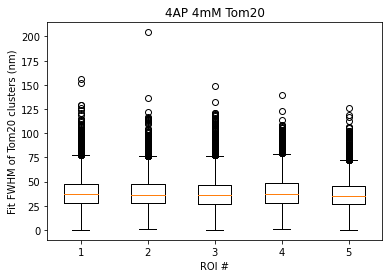

In [337]:
data = [df_4AP_4mM_1['sigma [nm]'], df_4AP_4mM_2['sigma [nm]'],df_4AP_4mM_3['sigma [nm]'],df_4AP_4mM_4['sigma [nm]'],df_4AP_4mM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('4AP 4mM Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### 4AP Controls Mean FWHM of Thunderstorm fits

In [338]:
df_4AP_control_1_sigma_mean = df_4AP_control_1.mean()['sigma [nm]']
df_4AP_control_1_sigma_std = df_4AP_control_1.std()['sigma [nm]']
df_4AP_control_2_sigma_mean = df_4AP_control_2.mean()['sigma [nm]']
df_4AP_control_2_sigma_std = df_4AP_control_2.std()['sigma [nm]']
df_4AP_control_3_sigma_mean = df_4AP_control_3.mean()['sigma [nm]']
df_4AP_control_3_sigma_std = df_4AP_control_3.std()['sigma [nm]']
df_4AP_control_4_sigma_mean = df_4AP_control_4.mean()['sigma [nm]']
df_4AP_control_4_sigma_std = df_4AP_control_4.std()['sigma [nm]']
df_4AP_control_5_sigma_mean = df_4AP_control_5.mean()['sigma [nm]']
df_4AP_control_5_sigma_std = df_4AP_control_5.std()['sigma [nm]']
print(f'{df_4AP_control_1_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_1_sigma_std:.1f}')
print(f'{df_4AP_control_2_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_2_sigma_std:.1f}')
print(f'{df_4AP_control_3_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_3_sigma_std:.1f}')
print(f'{df_4AP_control_4_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_4_sigma_std:.1f}')
print(f'{df_4AP_control_5_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_5_sigma_std:.1f}')

35.8  +/-  13.3
33.9  +/-  11.5
36.2  +/-  12.8
36.3  +/-  15.1
33.6  +/-  12.7


### 4AP Controls Boxplot

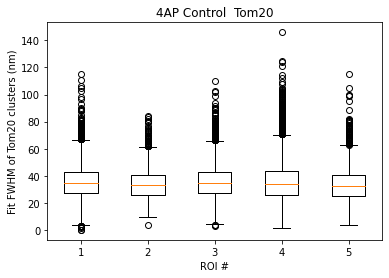

In [339]:
data = [df_4AP_control_1['sigma [nm]'], df_4AP_control_2['sigma [nm]'],df_4AP_control_3['sigma [nm]'],df_4AP_control_4['sigma [nm]'],df_4AP_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('4AP Control  Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

### Glutamate Mean FWHM of Thunderstorm fits

In [340]:
df_glutamate_0p1uM_1_sigma_mean = df_glutamate_0p1uM_1.mean()['sigma [nm]']
df_glutamate_0p1uM_1_sigma_std = df_glutamate_0p1uM_1.std()['sigma [nm]']
df_glutamate_0p1uM_2_sigma_mean = df_glutamate_0p1uM_2.mean()['sigma [nm]']
df_glutamate_0p1uM_2_sigma_std = df_glutamate_0p1uM_2.std()['sigma [nm]']
df_glutamate_0p1uM_3_sigma_mean = df_glutamate_0p1uM_3.mean()['sigma [nm]']
df_glutamate_0p1uM_3_sigma_std = df_glutamate_0p1uM_3.std()['sigma [nm]']
df_glutamate_0p1uM_4_sigma_mean = df_glutamate_0p1uM_4.mean()['sigma [nm]']
df_glutamate_0p1uM_4_sigma_std = df_glutamate_0p1uM_4.std()['sigma [nm]']
df_glutamate_0p1uM_5_sigma_mean = df_glutamate_0p1uM_5.mean()['sigma [nm]']
df_glutamate_0p1uM_5_sigma_std = df_glutamate_0p1uM_5.std()['sigma [nm]']
print(f'{df_glutamate_0p1uM_1_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_1_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_2_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_2_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_3_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_3_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_4_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_4_sigma_std:.1f}')
print(f'{df_glutamate_0p1uM_5_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_5_sigma_std:.1f}')

35.9  +/-  13.5
34.8  +/-  13.4
31.8  +/-  12.2
35.7  +/-  13.5
36.2  +/-  13.8


### Glutamate Boxplots

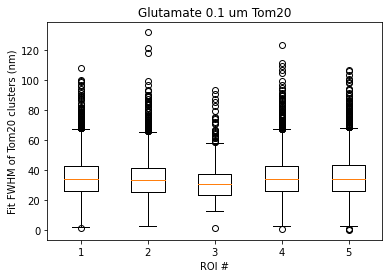

In [341]:
data = [df_glutamate_0p1uM_1['sigma [nm]'], df_glutamate_0p1uM_2['sigma [nm]'],df_glutamate_0p1uM_3['sigma [nm]'],df_glutamate_0p1uM_4['sigma [nm]'],df_glutamate_0p1uM_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glutamate 0.1 um Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

###  Glutmate Controls Mean FWHM of Thunderstorm fits

In [342]:
df_glutamate_control_1_sigma_mean = df_glutamate_control_1.mean()['sigma [nm]']
df_glutamate_control_1_sigma_std = df_glutamate_control_1.std()['sigma [nm]']
df_glutamate_control_2_sigma_mean = df_glutamate_control_2.mean()['sigma [nm]']
df_glutamate_control_2_sigma_std = df_glutamate_control_2.std()['sigma [nm]']
df_glutamate_control_3_sigma_mean = df_glutamate_control_3.mean()['sigma [nm]']
df_glutamate_control_3_sigma_std = df_glutamate_control_3.std()['sigma [nm]']
df_glutamate_control_4_sigma_mean = df_glutamate_control_4.mean()['sigma [nm]']
df_glutamate_control_4_sigma_std = df_glutamate_control_4.std()['sigma [nm]']
df_glutamate_control_5_sigma_mean = df_glutamate_control_5.mean()['sigma [nm]']
df_glutamate_control_5_sigma_std = df_glutamate_control_5.std()['sigma [nm]']
print(f'{df_glutamate_control_1_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_1_sigma_std:.1f}')
print(f'{df_glutamate_control_2_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_2_sigma_std:.1f}')
print(f'{df_glutamate_control_3_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_3_sigma_std:.1f}')
print(f'{df_glutamate_control_4_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_4_sigma_std:.1f}')
print(f'{df_glutamate_control_5_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_5_sigma_std:.1f}')

40.8  +/-  17.4
40.7  +/-  15.3
36.2  +/-  14.1
35.3  +/-  13.1
38.8  +/-  15.6


### Glutamate Controls Boxplot

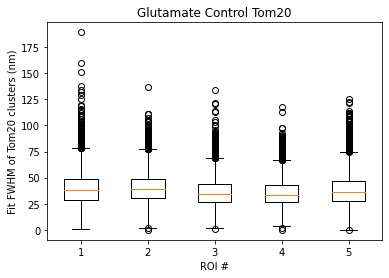

In [343]:
data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Glutamate Control Tom20')
ax1.set_xlabel('ROI #')
ax1.boxplot(data)
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

## Now combine the data from each condition.

In [344]:
df_4AP_4mM = df_4AP_4mM_1.append(df_4AP_4mM_2, sort=False, ignore_index=True)
df_4AP_4mM = df_4AP_4mM.append(df_4AP_4mM_3, sort=False, ignore_index=True)
df_4AP_4mM = df_4AP_4mM.append(df_4AP_4mM_4, sort=False, ignore_index=True)
df_4AP_4mM = df_4AP_4mM.append(df_4AP_4mM_5, sort=False, ignore_index=True)
df_4AP_4mM_sigma_mean = df_4AP_4mM.mean()['sigma [nm]']
df_4AP_4mM_sigma_std = df_4AP_4mM.std()['sigma [nm]']
print('4AP 4mM sigma mean +/- std')
print(f'{df_4AP_4mM_sigma_mean:.1f}', ' +/- ', f'{df_4AP_4mM_sigma_std:.1f}')

4AP 4mM sigma mean +/- std
38.4  +/-  16.6


In [345]:
df_4AP_control = df_4AP_control_1.append(df_4AP_control_2, sort=False, ignore_index=True)
df_4AP_control = df_4AP_control.append(df_4AP_control_3, sort=False, ignore_index=True)
df_4AP_control = df_4AP_control.append(df_4AP_control_4, sort=False, ignore_index=True)
df_4AP_control = df_4AP_control.append(df_4AP_control_5, sort=False, ignore_index=True)
df_4AP_control_sigma_mean = df_4AP_control.mean()['sigma [nm]']
df_4AP_control_sigma_std = df_4AP_control.std()['sigma [nm]']
print('4AP Control sigma mean +/- std')
print(f'{df_4AP_control_sigma_mean:.1f}', ' +/- ', f'{df_4AP_control_sigma_std:.1f}')

4AP Control sigma mean +/- std
35.5  +/-  13.7


In [346]:
df_glutamate_0p1uM = df_glutamate_0p1uM_1.append(df_glutamate_0p1uM_2, sort=False, ignore_index=True)
df_glutamate_0p1uM = df_glutamate_0p1uM.append(df_glutamate_0p1uM_3, sort=False, ignore_index=True)
df_glutamate_0p1uM = df_glutamate_0p1uM.append(df_glutamate_0p1uM_4, sort=False, ignore_index=True)
df_glutamate_0p1uM = df_glutamate_0p1uM.append(df_glutamate_0p1uM_5, sort=False, ignore_index=True)
df_glutamate_0p1uM_sigma_mean = df_glutamate_0p1uM.mean()['sigma [nm]']
df_glutamate_0p1uM_sigma_std = df_glutamate_0p1uM.std()['sigma [nm]']
print('Glutamate 0.1 uM sigma mean +/- std')
print(f'{df_glutamate_0p1uM_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_0p1uM_sigma_std:.1f}')

Glutamate 0.1 uM sigma mean +/- std
35.4  +/-  13.5


In [347]:
df_glutamate_control = df_glutamate_control_1.append(df_glutamate_control_2, sort=False, ignore_index=True)
df_glutamate_control = df_glutamate_control.append(df_glutamate_control_3, sort=False, ignore_index=True)
df_glutamate_control = df_glutamate_control.append(df_glutamate_control_4, sort=False, ignore_index=True)
df_glutamate_control = df_glutamate_control.append(df_glutamate_control_5, sort=False, ignore_index=True)
df_glutamate_control_sigma_mean = df_glutamate_control.mean()['sigma [nm]']
df_glutamate_control_sigma_std = df_glutamate_control.std()['sigma [nm]']
print('Glutamate Control sigma mean +/- std')
print(f'{df_glutamate_control_sigma_mean:.1f}', ' +/- ', f'{df_glutamate_control_sigma_std:.1f}')

Glutamate Control sigma mean +/- std
38.4  +/-  15.4


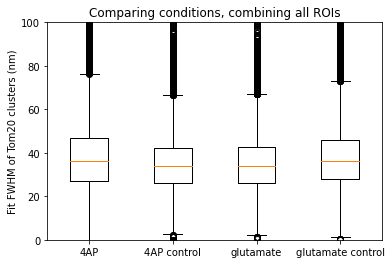

In [348]:
data = [df_4AP_4mM['sigma [nm]'], df_4AP_control['sigma [nm]'],df_glutamate_0p1uM['sigma [nm]'],df_glutamate_control['sigma [nm]']]
fig1, ax1 = plt.subplots()
ax1.set_title('Comparing conditions, combining all ROIs')
ax1.boxplot(data, labels=['4AP','4AP control','glutamate','glutamate control'])
ax1.set_ylim([0,100])
ax1.set_ylabel('Fit FWHM of Tom20 clusters (nm)')
plt.show()

# Now find the spot density by using the Mitos masks

In [349]:
mask_4AP_4mM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_1_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_2_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_3_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_4_deconv_10_ClassifierResult.tif')/255
mask_4AP_4mM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_5_deconv_10_ClassifierResult.tif')/255

In [350]:
mask_4AP_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_1_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_2_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_3_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_4_deconv_10_ClassifierResult.tif')/255
mask_4AP_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_5_deconv_10_ClassifierResult.tif')/255

In [351]:
mask_glutamate_0p1uM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_1_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_2_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_3_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_4_deconv_10_ClassifierResult.tif')/255
mask_glutamate_0p1uM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_5_deconv_10_ClassifierResult.tif')/255

In [352]:
mask_glutamate_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_1_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_2_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_3_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_4_deconv_10_ClassifierResult.tif')/255
mask_glutamate_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_5_deconv_10_ClassifierResult.tif')/255

### Find the total area of mitos in spots per pixel of mitos.
Scale to spots/micron^2 by dividing by 1 pixel/(.020 um)^2

In [355]:
dens_4AP_4mM_1 = (df_4AP_4mM_1.shape[0]/np.sum(mask_4AP_4mM_1))/(0.02**2)
dens_4AP_4mM_2 = (df_4AP_4mM_2.shape[0]/np.sum(mask_4AP_4mM_2))/(0.02**2)
dens_4AP_4mM_3 = (df_4AP_4mM_3.shape[0]/np.sum(mask_4AP_4mM_3))/(0.02**2)
dens_4AP_4mM_4 = (df_4AP_4mM_4.shape[0]/np.sum(mask_4AP_4mM_4))/(0.02**2)
dens_4AP_4mM_5 = (df_4AP_4mM_5.shape[0]/np.sum(mask_4AP_4mM_5))/(0.02**2)
#print((df_4AP_4mM_1.shape[0]/np.sum(mask_4AP_4mM_1) + df_4AP_4mM_2.shape[0]/np.sum(mask_4AP_4mM_2)+df_4AP_4mM_3.shape[0]/np.sum(mask_4AP_4mM_3)+df_4AP_4mM_4.shape[0]/np.sum(mask_4AP_4mM_4)+df_4AP_4mM_5.shape[0]/np.sum(mask_4AP_4mM_5))/5)

In [357]:
print(dens_4AP_4mM_1)
print(dens_4AP_4mM_2)
print(dens_4AP_4mM_3)
print(dens_4AP_4mM_4)
print(dens_4AP_4mM_5)
print((dens_4AP_4mM_1+dens_4AP_4mM_2+dens_4AP_4mM_3+dens_4AP_4mM_4+dens_4AP_4mM_5)/5)

51.40522498855801
47.148409733670086
49.71953085160632
56.24963355287588
52.33065755009265
51.3706913353606


In [358]:
dens_4AP_control_1 = (df_4AP_control_1.shape[0]/np.sum(mask_4AP_control_1))/(0.02**2)
dens_4AP_control_2 = (df_4AP_control_2.shape[0]/np.sum(mask_4AP_control_2))/(0.02**2)
dens_4AP_control_3 = (df_4AP_control_3.shape[0]/np.sum(mask_4AP_control_3))/(0.02**2)
dens_4AP_control_4 = (df_4AP_control_4.shape[0]/np.sum(mask_4AP_control_4))/(0.02**2)
dens_4AP_control_5 = (df_4AP_control_5.shape[0]/np.sum(mask_4AP_control_5))/(0.02**2)

In [359]:
print(dens_4AP_control_1)
print(dens_4AP_control_2)
print(dens_4AP_control_3)
print(dens_4AP_control_4)
print(dens_4AP_control_5)
print((dens_4AP_control_1+dens_4AP_control_2+dens_4AP_control_3+dens_4AP_control_4+dens_4AP_control_5)/5)

61.53059697770684
71.35302876386356
64.76325687735084
50.572447306263065
69.45488178507428
63.53484234205172


In [360]:
dens_glutamate_0p1uM_1 = (df_glutamate_0p1uM_1.shape[0]/np.sum(mask_glutamate_0p1uM_1))/(0.02**2)
dens_glutamate_0p1uM_2 = (df_glutamate_0p1uM_2.shape[0]/np.sum(mask_glutamate_0p1uM_2))/(0.02**2)
dens_glutamate_0p1uM_3 = (df_glutamate_0p1uM_3.shape[0]/np.sum(mask_glutamate_0p1uM_3))/(0.02**2)
dens_glutamate_0p1uM_4 = (df_glutamate_0p1uM_4.shape[0]/np.sum(mask_glutamate_0p1uM_4))/(0.02**2)
dens_glutamate_0p1uM_5 = (df_glutamate_0p1uM_5.shape[0]/np.sum(mask_glutamate_0p1uM_5))/(0.02**2)

In [361]:
print(dens_glutamate_0p1uM_1)
print(dens_glutamate_0p1uM_2)
print(dens_glutamate_0p1uM_3)
print(dens_glutamate_0p1uM_4)
print(dens_glutamate_0p1uM_5)
print((dens_glutamate_0p1uM_1+dens_glutamate_0p1uM_2+dens_glutamate_0p1uM_3+dens_glutamate_0p1uM_4+dens_glutamate_0p1uM_5)/5)

59.60011225983601
68.10516633450867
90.36537625054372
61.644763582170434
58.98678162015755
67.74044000944328


In [362]:
dens_glutamate_control_1 = (df_glutamate_control_1.shape[0]/np.sum(mask_glutamate_control_1))/(0.02**2)
dens_glutamate_control_2 = (df_glutamate_control_2.shape[0]/np.sum(mask_glutamate_control_2))/(0.02**2)
dens_glutamate_control_3 = (df_glutamate_control_3.shape[0]/np.sum(mask_glutamate_control_3))/(0.02**2)
dens_glutamate_control_4 = (df_glutamate_control_4.shape[0]/np.sum(mask_glutamate_control_4))/(0.02**2)
dens_glutamate_control_5 = (df_glutamate_control_5.shape[0]/np.sum(mask_glutamate_control_5))/(0.02**2)

In [363]:
print(dens_glutamate_control_1)
print(dens_glutamate_control_2)
print(dens_glutamate_control_3)
print(dens_glutamate_control_4)
print(dens_glutamate_control_5)
print((dens_glutamate_control_1+dens_glutamate_control_2+dens_glutamate_control_3+dens_glutamate_control_4+dens_glutamate_control_5)/5)

46.57340694754262
48.77445953691871
57.45228290921101
61.72934234655904
49.13716085954765
52.7333305199558


## Mitos variance of fluorescence
From the Tom20 STED paper:
"Variance Analysis. To exclude an influence of the image segmen- tation process on the determined variance values, the local variance in the fluorescence intensity of raw STED images was calculated before image segmentation. To this end, the variance was determined in round ROIs with a diameter of seven pixels (∼140 nm). The resulting variance values were assigned to the central pixel of the analyzed ROI. To evaluate the results of the analysis independently from the absolute brightness of the struc- tures,
theindividual variancevalues werenormalized to the
squared average fluorescence intensity of the respective ROI. The variance calculation was repeated using each pixel successively as an ROI center, leading to an image in which each pixel represents the local variance. Finally, the mitochondria-containing fraction of the image was selected by image segmentation using masks as described above. Then, the median of the variance within the mitochondria was determined."

In [4]:
raw_4AP_4mM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_1_raw.tif')
raw_4AP_4mM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_2_raw.tif')
raw_4AP_4mM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_3_raw.tif')
raw_4AP_4mM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_4_raw.tif')
raw_4AP_4mM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_4mM_5_raw.tif')

In [5]:
raw_4AP_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_1_raw.tif')
raw_4AP_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_2_raw.tif')
raw_4AP_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_3_raw.tif')
raw_4AP_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_4_raw.tif')
raw_4AP_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/4AP_control_5_raw.tif')

In [6]:
raw_glutamate_0p1uM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_1_raw.tif')
raw_glutamate_0p1uM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_2_raw.tif')
raw_glutamate_0p1uM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_3_raw.tif')
raw_glutamate_0p1uM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_4_raw.tif')
raw_glutamate_0p1uM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_0p1uM_5_raw.tif')

In [7]:
raw_glutamate_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_1_raw.tif')
raw_glutamate_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_2_raw.tif')
raw_glutamate_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_3_raw.tif')
raw_glutamate_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_4_raw.tif')
raw_glutamate_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_raw/glutamate_control_5_raw.tif')

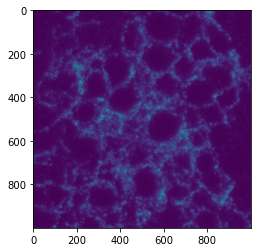

In [8]:
plt.imshow(raw_4AP_4mM_1)


At each point that is far enough from an edge
select out the ROI values with pixel centers <= r+1/2 from (i,j)
Take the variance
put at the center pixel value for the new var matrix.

In [122]:
# r must be positive
### fluo_var_image generates an image of the variance of the fluorescence for an image with an ROI half radius, rounded down, of r.
def fluo_var_image(image,r):
    (xmax,ymax)=image.shape
    var_image = np.zeros((xmax,ymax))
    select_mat = np.zeros((2*r+1,2*r+1))
    for p in range(2*r+1):
        for q in range(2*r+1):
            if (m.sqrt((p-(r))**2 + (q-(r))**2) <= (r+0.5)):
                select_mat[p,q] = 1
            else:
                select_mat[p,q] = np.nan
    for i in range(xmax):
        for j in range(ymax):
            if ((i-r) > 0 and (i+r) < (xmax-1)) and ((j-r) > 0 and (j+r) < (ymax-1)):
               # roi = np.multiply(image[i-r:i+r+1,j-r:j+r+1],select_mat)
                roi = np.multiply(image[i-r:i+r+1,j-r:j+r+1],select_mat)
                var_image[i,j] = np.nanvar(roi)/(np.nanmean(roi)**2)
    return var_image

Check if it's all zeros or all ones that I get what I expect (zero and undefined)

In [123]:
test_ones = np.ones((128,128))
test_zeros = np.zeros((128,128))
print(fluo_var_image(test_ones,3))
print(fluo_var_image(test_zeros,3))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/var/folders/_n/8p0r8jdj1zl2x6wdg499kh000000gn/T/ipykernel_42404/1007249930.py:18: RuntimeWarning: invalid value encountered in double_scalars
  var_image[i,j] = np.nanvar(roi)/(np.nanmean(roi)**2)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Test on Random image

In [124]:
a = np.random.rand(10000)
a=50 * a
image =np.reshape(a,(100,100))
test = fluo_var_image(image, 3)

The Values I'm getting are all below one and most are closer to 0 than 1, as expected from a random number distribution on \[0,1]

/var/folders/_n/8p0r8jdj1zl2x6wdg499kh000000gn/T/ipykernel_42404/2234150431.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1)


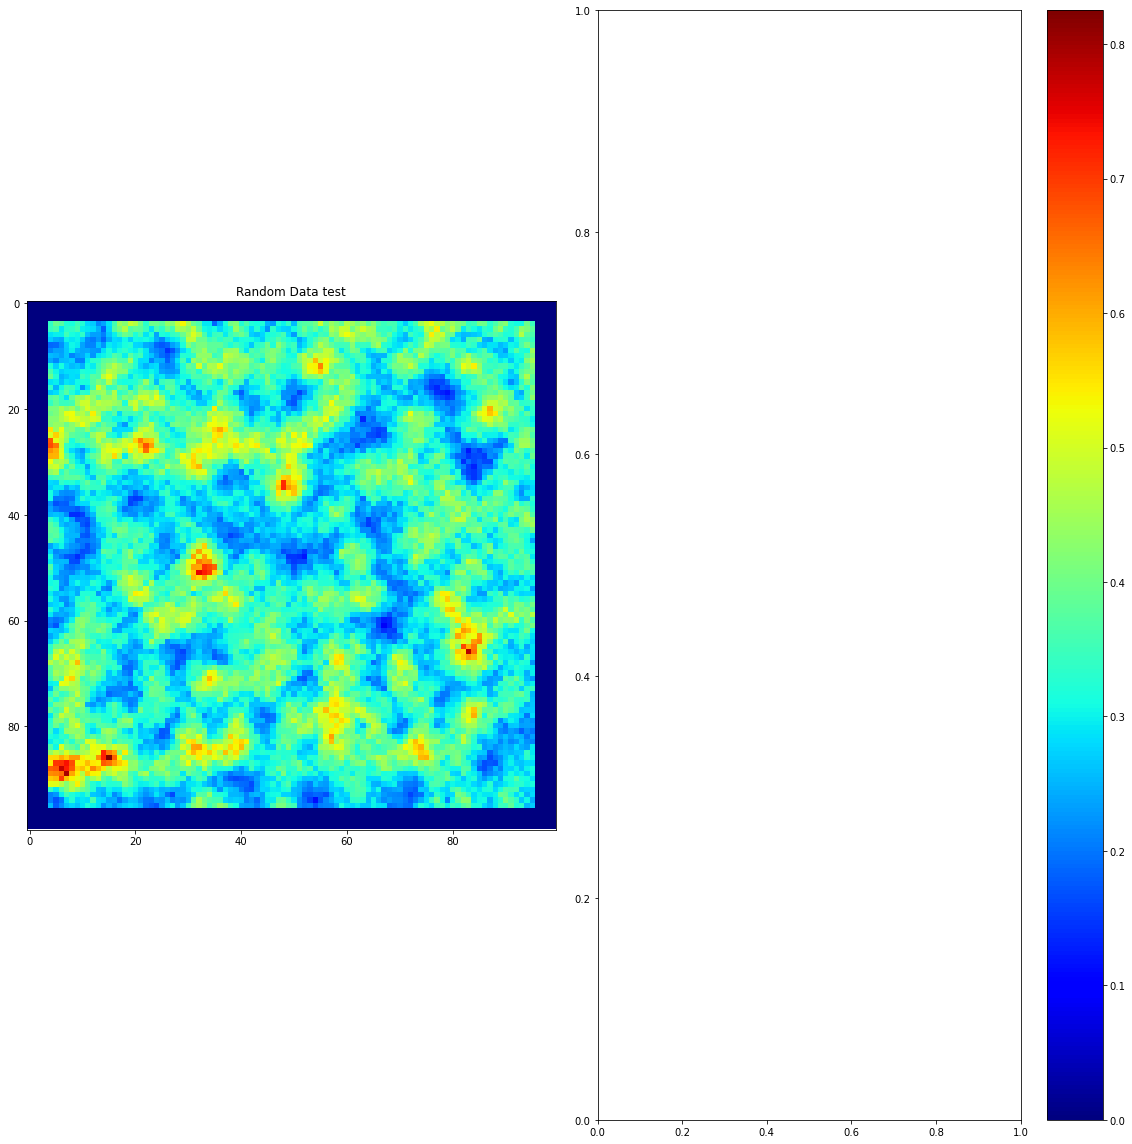

In [125]:
fig, ax = plt.subplots(figsize=(16,16), nrows=1,ncols=2)
plt.tight_layout() 
#Gaussian Excitation

im1 = ax[0].imshow(test,cmap='jet'); ax[0].set_title('Random Data test')
plt.colorbar(im1)
plt.show()

### Now run calculation on the images.
* First calcualte the normalized fluorescence image
* Then use the mito mask to select only the normalized fluorescence values inside the mitos
* Then calculate the median normalized fluorescence in each image and for each condition find the total median.

### 4AP Normalized Variance of Fluorescence Calculation

In [126]:
normvar_4AP_4mM_1 = fluo_var_image(raw_4AP_4mM_1,3)

In [127]:
normvar_4AP_4mM_2 = fluo_var_image(raw_4AP_4mM_2,3)

In [128]:
normvar_4AP_4mM_3 = fluo_var_image(raw_4AP_4mM_3,3)

In [129]:
normvar_4AP_4mM_4 = fluo_var_image(raw_4AP_4mM_4,3)

In [130]:
normvar_4AP_4mM_5 = fluo_var_image(raw_4AP_4mM_5,3)

### Ok find an array with values of normalized fluoresence for mitos after masking
4AP_4mM

In [75]:
mask_4AP_4mM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_1_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_2_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_3_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_4_deconv_10_ClassifierResult.tif')
mask_4AP_4mM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_4mM_5_deconv_10_ClassifierResult.tif')

Multiply normalized variance image by mask, then divide by 255 since it's 8-bit.

In [131]:
nvarr_m_4AP_4mM_1 = np.multiply(mask_4AP_4mM_1,normvar_4AP_4mM_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_4AP_4mM_1 = nvarr_m_4AP_4mM_1[nvarr_m_4AP_4mM_1 != 0]
nvarr_m_4AP_4mM_2 = np.multiply(mask_4AP_4mM_2, normvar_4AP_4mM_2)/255
nvarr_f_4AP_4mM_2 = nvarr_m_4AP_4mM_2[nvarr_m_4AP_4mM_2 != 0]
nvarr_m_4AP_4mM_3 = np.multiply(mask_4AP_4mM_3,normvar_4AP_4mM_3)/255
nvarr_f_4AP_4mM_3 = nvarr_m_4AP_4mM_3[nvarr_m_4AP_4mM_3 != 0]
nvarr_m_4AP_4mM_4 = np.multiply(mask_4AP_4mM_4,normvar_4AP_4mM_4)/255
nvarr_f_4AP_4mM_4 = nvarr_m_4AP_4mM_4[nvarr_m_4AP_4mM_4 != 0]
nvarr_m_4AP_4mM_5 = np.multiply(mask_4AP_4mM_5,normvar_4AP_4mM_5)/255
nvarr_f_4AP_4mM_5 = nvarr_m_4AP_4mM_5[nvarr_m_4AP_4mM_5 != 0]

(array([2.02817e+05, 5.69130e+04, 4.87100e+03, 1.50500e+03, 6.38000e+02,
        2.06000e+02, 7.40000e+01, 3.40000e+01, 1.90000e+01, 2.00000e+00]),
 array([0.01483042, 0.15543722, 0.29604403, 0.43665083, 0.57725763,
        0.71786443, 0.85847123, 0.99907803, 1.13968483, 1.28029164,
        1.42089844]),
 <BarContainer object of 10 artists>)

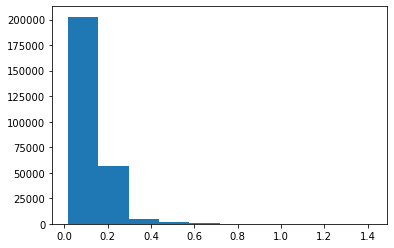

In [132]:
#nvarr_f_4AP_4mM_1.shape
x = np.arange(0,267079, 1)
plt.hist(nvarr_f_4AP_4mM_1)

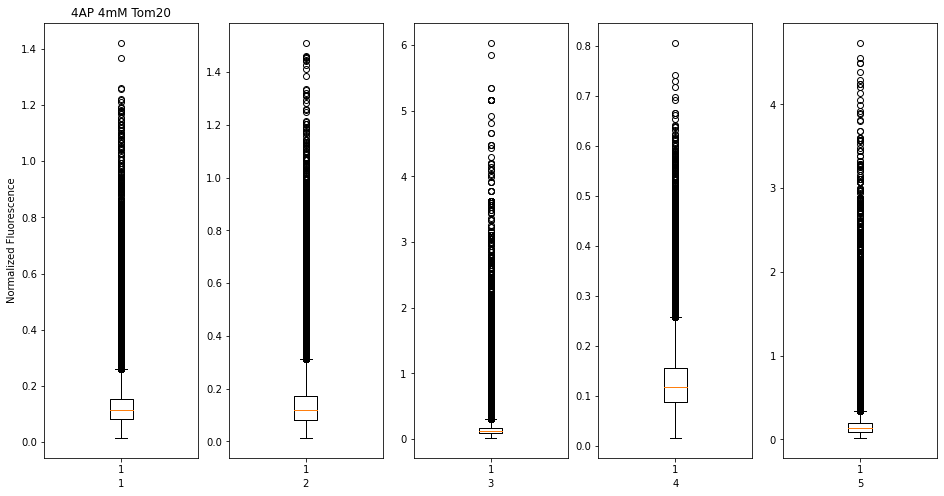

In [133]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('4AP 4mM Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_4AP_4mM_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_4AP_4mM_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_4AP_4mM_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_4AP_4mM_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_4AP_4mM_5)
plt.show()

In [134]:
print(np.median(nvarr_f_4AP_4mM_1))
print(np.median(nvarr_f_4AP_4mM_2))
print(np.median(nvarr_f_4AP_4mM_3))
print(np.median(nvarr_f_4AP_4mM_4))
print(np.median(nvarr_f_4AP_4mM_5))

0.11305840059435475
0.11722973754191236
0.1185429715518706
0.11711540304517204
0.1303799904532115


In [137]:
print(np.std(nvarr_f_4AP_4mM_1))
print(np.std(nvarr_f_4AP_4mM_2))
print(np.std(nvarr_f_4AP_4mM_3))
print(np.std(nvarr_f_4AP_4mM_4))
print(np.std(nvarr_f_4AP_4mM_5))

0.07510264696275525
0.0947317371784894
0.2245933342291721
0.059147944748770304
0.23608146862381962


Wait a second, the standard deviation is higher than the median for some of these images's normalized fluorescence values!  Weird.  It's for the images where there are values really far from the median...might want to throw away some outliers but how to decide?

### 4AP Control Normalized Variance of Fluorescence Calculation

In [23]:
mask_4AP_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_1_deconv_10_ClassifierResult.tif')
mask_4AP_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_2_deconv_10_ClassifierResult.tif')
mask_4AP_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_3_deconv_10_ClassifierResult.tif')
mask_4AP_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_4_deconv_10_ClassifierResult.tif')
mask_4AP_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/4AP_control_5_deconv_10_ClassifierResult.tif')

In [144]:
normvar_4AP_control_1 = fluo_var_image(raw_4AP_control_1,3)

In [145]:
normvar_4AP_control_2 = fluo_var_image(raw_4AP_control_2,3)

In [146]:
normvar_4AP_control_3 = fluo_var_image(raw_4AP_control_3,3)

In [147]:
normvar_4AP_control_4 = fluo_var_image(raw_4AP_control_4,3)

In [148]:
normvar_4AP_control_5 = fluo_var_image(raw_4AP_control_5,3)

In [155]:
nvarr_m_4AP_control_1 = np.multiply(mask_4AP_control_1,normvar_4AP_control_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_4AP_control_1 = nvarr_m_4AP_control_1[nvarr_m_4AP_control_1 != 0]
nvarr_m_4AP_control_2 = np.multiply(mask_4AP_control_2, normvar_4AP_control_2)/255
nvarr_f_4AP_control_2 = nvarr_m_4AP_control_2[nvarr_m_4AP_control_2 != 0]
nvarr_m_4AP_control_3 = np.multiply(mask_4AP_control_3,normvar_4AP_control_3)/255
nvarr_f_4AP_control_3 = nvarr_m_4AP_control_3[nvarr_m_4AP_control_3 != 0]
nvarr_m_4AP_control_4 = np.multiply(mask_4AP_control_4,normvar_4AP_control_4)/255
nvarr_f_4AP_control_4 = nvarr_m_4AP_control_4[nvarr_m_4AP_control_4 != 0]
nvarr_m_4AP_control_5 = np.multiply(mask_4AP_control_5,normvar_4AP_control_5)/255
nvarr_f_4AP_control_5 = nvarr_m_4AP_control_5[nvarr_m_4AP_control_5 != 0]

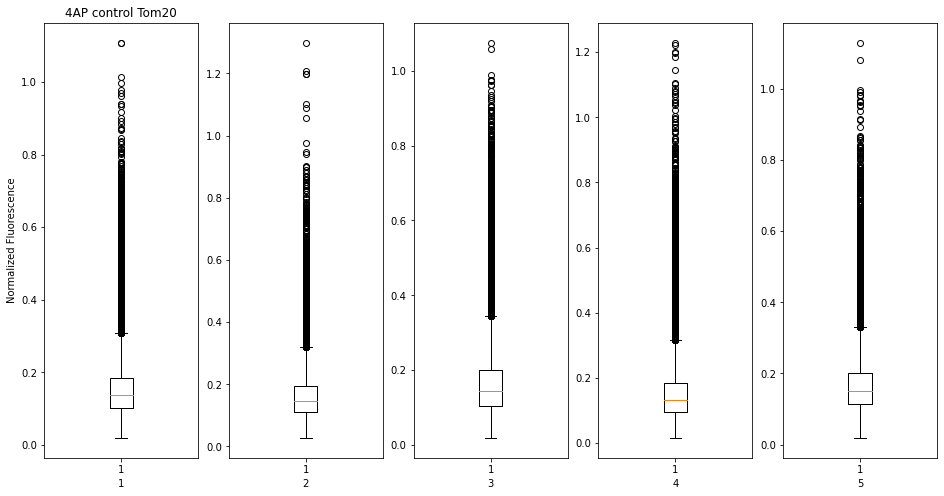

In [156]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('4AP control Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_4AP_control_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_4AP_control_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_4AP_control_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_4AP_control_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_4AP_control_5)
plt.show()

In [157]:
print(np.median(nvarr_f_4AP_control_1))
print(np.median(nvarr_f_4AP_control_2))
print(np.median(nvarr_f_4AP_control_3))
print(np.median(nvarr_f_4AP_control_4))
print(np.median(nvarr_f_4AP_control_5))

0.13810686561466595
0.1471525965827792
0.14513607991234373
0.13204508856682767
0.15027573098676433


In [159]:
print(np.std(nvarr_f_4AP_control_1))
print(np.std(nvarr_f_4AP_control_2))
print(np.std(nvarr_f_4AP_control_3))
print(np.std(nvarr_f_4AP_control_4))
print(np.std(nvarr_f_4AP_control_5))

0.07566312747235168
0.07666459482406247
0.09019896800400647
0.07929712449118854
0.0825336218831287


### Glutamate Normalized Variance of Fluorescence Calculation

In [138]:
mask_glutamate_0p1uM_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_1_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_2_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_3_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_4_deconv_10_ClassifierResult.tif')
mask_glutamate_0p1uM_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_0p1uM_5_deconv_10_ClassifierResult.tif')

In [139]:
normvar_glutamate_0p1uM_1 = fluo_var_image(raw_glutamate_0p1uM_1,3)

In [140]:
normvar_glutamate_0p1uM_2 = fluo_var_image(raw_glutamate_0p1uM_2,3)

In [141]:
normvar_glutamate_0p1uM_3 = fluo_var_image(raw_glutamate_0p1uM_3,3)

In [142]:
normvar_glutamate_0p1uM_4 = fluo_var_image(raw_glutamate_0p1uM_4,3)

In [143]:
normvar_glutamate_0p1uM_5 = fluo_var_image(raw_glutamate_0p1uM_5,3)

In [160]:
nvarr_m_glutamate_0p1uM_1 = np.multiply(mask_glutamate_0p1uM_1,normvar_glutamate_0p1uM_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_glutamate_0p1uM_1 = nvarr_m_glutamate_0p1uM_1[nvarr_m_glutamate_0p1uM_1 != 0]
nvarr_m_glutamate_0p1uM_2 = np.multiply(mask_glutamate_0p1uM_2, normvar_glutamate_0p1uM_2)/255
nvarr_f_glutamate_0p1uM_2 = nvarr_m_glutamate_0p1uM_2[nvarr_m_glutamate_0p1uM_2 != 0]
nvarr_m_glutamate_0p1uM_3 = np.multiply(mask_glutamate_0p1uM_3,normvar_glutamate_0p1uM_3)/255
nvarr_f_glutamate_0p1uM_3 = nvarr_m_glutamate_0p1uM_3[nvarr_m_glutamate_0p1uM_3 != 0]
nvarr_m_glutamate_0p1uM_4 = np.multiply(mask_glutamate_0p1uM_4,normvar_glutamate_0p1uM_4)/255
nvarr_f_glutamate_0p1uM_4 = nvarr_m_glutamate_0p1uM_4[nvarr_m_glutamate_0p1uM_4 != 0]
nvarr_m_glutamate_0p1uM_5 = np.multiply(mask_glutamate_0p1uM_5,normvar_glutamate_0p1uM_5)/255
nvarr_f_glutamate_0p1uM_5 = nvarr_m_glutamate_0p1uM_5[nvarr_m_glutamate_0p1uM_5 != 0]

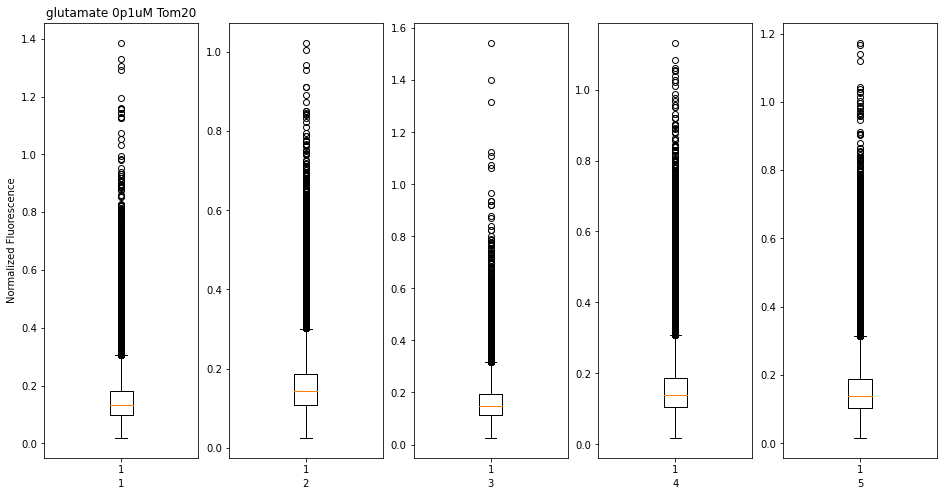

In [161]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('glutamate 0p1uM Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_glutamate_0p1uM_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_glutamate_0p1uM_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_glutamate_0p1uM_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_glutamate_0p1uM_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_glutamate_0p1uM_5)
plt.show()

In [162]:
print(np.median(nvarr_f_glutamate_0p1uM_1))
print(np.median(nvarr_f_glutamate_0p1uM_2))
print(np.median(nvarr_f_glutamate_0p1uM_3))
print(np.median(nvarr_f_glutamate_0p1uM_4))
print(np.median(nvarr_f_glutamate_0p1uM_5))

0.13418572309683896
0.14226077159071898
0.14940828402366868
0.13900898502537012
0.13835294202331164


In [163]:
print(np.std(nvarr_f_glutamate_0p1uM_1))
print(np.std(nvarr_f_glutamate_0p1uM_2))
print(np.std(nvarr_f_glutamate_0p1uM_3))
print(np.std(nvarr_f_glutamate_0p1uM_4))
print(np.std(nvarr_f_glutamate_0p1uM_5))

0.0755834604084878
0.06827660498735977
0.08140591821892178
0.07601239712897984
0.08003538383002907


### Glutamate Control Normalized Variance of the Fluorescence Calculation

In [149]:
mask_glutamate_control_1 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_1_deconv_10_ClassifierResult.tif')
mask_glutamate_control_2 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_2_deconv_10_ClassifierResult.tif')
mask_glutamate_control_3 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_3_deconv_10_ClassifierResult.tif')
mask_glutamate_control_4 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_4_deconv_10_ClassifierResult.tif')
mask_glutamate_control_5 = plt.imread('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/STED_deconv_10iter_seg1_FilledOpenMasks/glutamate_control_5_deconv_10_ClassifierResult.tif')

In [150]:
normvar_glutamate_control_1 = fluo_var_image(raw_glutamate_control_1,3)

In [151]:
normvar_glutamate_control_2 = fluo_var_image(raw_glutamate_control_2,3)

In [152]:
normvar_glutamate_control_3 = fluo_var_image(raw_glutamate_control_3,3)

In [153]:
normvar_glutamate_control_4 = fluo_var_image(raw_glutamate_control_4,3)

In [154]:
normvar_glutamate_control_5 = fluo_var_image(raw_glutamate_control_5,3)

In [164]:
nvarr_m_glutamate_control_1 = np.multiply(mask_glutamate_control_1,normvar_glutamate_control_1)/255 #m=masked, f=final version with 0's removed
nvarr_f_glutamate_control_1 = nvarr_m_glutamate_control_1[nvarr_m_glutamate_control_1 != 0]
nvarr_m_glutamate_control_2 = np.multiply(mask_glutamate_control_2, normvar_glutamate_control_2)/255
nvarr_f_glutamate_control_2 = nvarr_m_glutamate_control_2[nvarr_m_glutamate_control_2 != 0]
nvarr_m_glutamate_control_3 = np.multiply(mask_glutamate_control_3,normvar_glutamate_control_3)/255
nvarr_f_glutamate_control_3 = nvarr_m_glutamate_control_3[nvarr_m_glutamate_control_3 != 0]
nvarr_m_glutamate_control_4 = np.multiply(mask_glutamate_control_4,normvar_glutamate_control_4)/255
nvarr_f_glutamate_control_4 = nvarr_m_glutamate_control_4[nvarr_m_glutamate_control_4 != 0]
nvarr_m_glutamate_control_5 = np.multiply(mask_glutamate_control_5,normvar_glutamate_control_5)/255
nvarr_f_glutamate_control_5 = nvarr_m_glutamate_control_5[nvarr_m_glutamate_control_5 != 0]

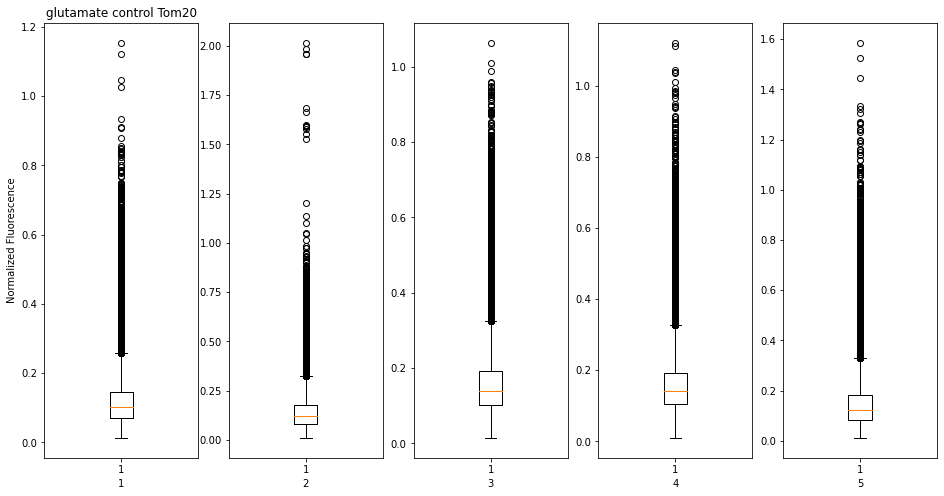

In [165]:
#data = [df_glutamate_control_1['sigma [nm]'], df_glutamate_control_2['sigma [nm]'],df_glutamate_control_3['sigma [nm]'],df_glutamate_control_4['sigma [nm]'],df_glutamate_control_5['sigma [nm]']]
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1,ncols=5)
ax1[0].set_title('glutamate control Tom20')
ax1[0].set_xlabel('1')
ax1[0].boxplot(nvarr_f_glutamate_control_1)
ax1[0].set_ylabel('Normalized Fluorescence')
ax1[1].set_xlabel('2')
ax1[1].boxplot(nvarr_f_glutamate_control_2)
ax1[2].set_xlabel('3')
ax1[2].boxplot(nvarr_f_glutamate_control_3)
ax1[3].set_xlabel('4')
ax1[3].boxplot(nvarr_f_glutamate_control_4)
ax1[4].set_xlabel('5')
ax1[4].boxplot(nvarr_f_glutamate_control_5)
plt.show()

In [166]:
print(np.median(nvarr_f_glutamate_control_1))
print(np.median(nvarr_f_glutamate_control_2))
print(np.median(nvarr_f_glutamate_control_3))
print(np.median(nvarr_f_glutamate_control_4))
print(np.median(nvarr_f_glutamate_control_5))

0.10212672672494748
0.11870985270430244
0.13952282139717076
0.14142716049382714
0.12306564411445495


In [167]:
print(np.std(nvarr_f_glutamate_control_1))
print(np.std(nvarr_f_glutamate_control_2))
print(np.std(nvarr_f_glutamate_control_3))
print(np.std(nvarr_f_glutamate_control_4))
print(np.std(nvarr_f_glutamate_control_5))

0.07248782801247376
0.09244430856710895
0.08205606764036125
0.08363577927296112
0.09546446951930129


## Now calculate the median and generate boxplots of each type of condition

In [168]:
print(np.median(np.concatenate((nvarr_f_4AP_4mM_1,nvarr_f_4AP_4mM_2,nvarr_f_4AP_4mM_3,nvarr_f_4AP_4mM_4,nvarr_f_4AP_4mM_5), axis=0)))

0.11904444444444444


In [169]:
print(np.median(np.concatenate((nvarr_f_4AP_control_1,nvarr_f_4AP_control_2,nvarr_f_4AP_control_3,nvarr_f_4AP_control_4,nvarr_f_4AP_control_5), axis=0)))

0.13882082126680034


In [170]:
print(np.median(np.concatenate((nvarr_f_glutamate_0p1uM_1,nvarr_f_glutamate_0p1uM_2,nvarr_f_glutamate_0p1uM_3,nvarr_f_glutamate_0p1uM_4,nvarr_f_glutamate_0p1uM_5), axis=0)))

0.1389676494034077


In [171]:
print(np.median(np.concatenate((nvarr_f_glutamate_control_1,nvarr_f_glutamate_control_2,nvarr_f_glutamate_control_3,nvarr_f_glutamate_control_4,nvarr_f_glutamate_control_5), axis=0)))

0.12349465257596683


# Now save the numpy arrays with the normalized fluorescence values for Emily, then she can compare the images to one another and the conditions to one another by binning the data together

4AP 4mM data:

In [172]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_1.csv', nvarr_f_4AP_4mM_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_2.csv', nvarr_f_4AP_4mM_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_3.csv', nvarr_f_4AP_4mM_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_4.csv', nvarr_f_4AP_4mM_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_4mM_5.csv', nvarr_f_4AP_4mM_5, delimiter=',')

4AP control data:

In [173]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_1.csv', nvarr_f_4AP_control_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_2.csv', nvarr_f_4AP_control_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_3.csv', nvarr_f_4AP_control_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_4.csv', nvarr_f_4AP_control_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_4AP_control_5.csv', nvarr_f_4AP_control_5, delimiter=',')

In [174]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_1.csv', nvarr_f_glutamate_0p1uM_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_2.csv', nvarr_f_glutamate_0p1uM_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_3.csv', nvarr_f_glutamate_0p1uM_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_4.csv', nvarr_f_glutamate_0p1uM_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_0p1uM_5.csv', nvarr_f_glutamate_0p1uM_5, delimiter=',')

In [175]:
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_1.csv', nvarr_f_glutamate_control_1, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_2.csv', nvarr_f_glutamate_control_2, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_3.csv', nvarr_f_glutamate_control_3, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_4.csv', nvarr_f_glutamate_control_4, delimiter=',')
np.savetxt('/Users/Stephanie/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/STED_FultonR_final_20210409/For Emily/nvarr_glutamate_control_5.csv', nvarr_f_glutamate_control_5, delimiter=',')